## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 3]

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                 min_lr=1e-12,
                                 monitor='val_loss',
                                 patience=reduce_patient,
                                 verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 6s 125us/step - loss: 1.2328 - acc: 0.5758 - val_loss: 1.4761 - val_acc: 0.4771
Epoch 14/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2086 - acc: 0.5840 - val_loss: 1.4695 - val_acc: 0.4842
Epoch 15/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.1844 - acc: 0.5929 - val_loss: 1.4648 - val_acc: 0.4828
Epoch 16/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.1626 - acc: 0.6023 - val_loss: 1.4573 - val_acc: 0.4916
Epoch 17/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.1390 - acc: 0.6094 - val_loss: 1.4616 - val_acc: 0.4865
Epoch 18/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1168 - acc: 0.6191 - val_loss: 1.4479 - val_acc: 0.4909
Epoch 19/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.0931 - acc: 0.6280 - val_loss: 1.4603 - val_acc: 0.4874
Epoch 20/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.5454 - acc: 0.1863 - val_loss: 2.1876 - val_acc: 0.1988
Epoch 2/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.0031 - acc: 0.3195 - val_loss: 2.0665 - val_acc: 0.2708
Epoch 3/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8509 - acc: 0.3636 - val_loss: 1.9524 - val_acc: 0.3211
Epoch 4/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.7693 - acc: 0.3872 - val_loss: 1.8598 - val_acc: 0.3491
Epoch 5/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.7145 - acc: 0.4043 - val_loss: 1.7917 - val_acc: 0.3717
Epoch 6/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.6706 - acc: 0.4192 - val_loss: 1.7456 - val_acc: 0.3842
Epoch 7/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6356 - acc: 0.4306 - val_loss: 1.7122 - 

50000/50000 [==============================] - 7s 134us/step - loss: 0.4360 - acc: 0.8722 - val_loss: 1.5677 - val_acc: 0.5205
Epoch 23/25
50000/50000 [==============================] - 7s 135us/step - loss: 0.4154 - acc: 0.8793 - val_loss: 1.5984 - val_acc: 0.5176
Epoch 24/25
50000/50000 [==============================] - 7s 140us/step - loss: 0.3964 - acc: 0.8864 - val_loss: 1.6949 - val_acc: 0.5144
Epoch 25/25
50000/50000 [==============================] - 7s 135us/step - loss: 0.3782 - acc: 0.8929 - val_loss: 1.6784 - val_acc: 0.5095
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________________________________

50000/50000 [==============================] - 7s 140us/step - loss: 1.3027 - acc: 0.5512 - val_loss: 1.5016 - val_acc: 0.4752
Epoch 8/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.2716 - acc: 0.5612 - val_loss: 1.4795 - val_acc: 0.4811
Epoch 9/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2418 - acc: 0.5740 - val_loss: 1.4873 - val_acc: 0.4795
Epoch 10/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.2161 - acc: 0.5827 - val_loss: 1.4669 - val_acc: 0.4865
Epoch 11/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.1903 - acc: 0.5919 - val_loss: 1.4748 - val_acc: 0.4850
Epoch 12/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1679 - acc: 0.6007 - val_loss: 1.4511 - val_acc: 0.4912
Epoch 13/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.1454 - acc: 0.6102 - val_loss: 1.4356 - val_acc: 0.4924
Epoch 14/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.8185 - acc: 0.3696 - val_loss: 2.2749 - val_acc: 0.2542
Epoch 2/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5394 - acc: 0.4551 - val_loss: 1.9319 - val_acc: 0.3229
Epoch 3/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.4277 - acc: 0.4962 - val_loss: 1.8803 - val_acc: 0.3512
Epoch 4/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.3592 - acc: 0.5204 - val_loss: 1.9239 - val_acc: 0.3025
Epoch 5/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.3009 - acc: 0.5420 - val_loss: 1.9683 - val_acc: 0.3337
Epoch 6/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2455 - acc: 0.5616 - val_loss: 1.8102 - val_acc: 0.3789
Epoch 7/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.2067 - acc: 0.5757 - val_loss: 2.4226 - 

50000/50000 [==============================] - 7s 131us/step - loss: 0.7014 - acc: 0.7857 - val_loss: 1.3840 - val_acc: 0.5255
Epoch 22/25
50000/50000 [==============================] - 7s 133us/step - loss: 0.6932 - acc: 0.7877 - val_loss: 1.4007 - val_acc: 0.5225
Epoch 23/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.6847 - acc: 0.7916 - val_loss: 1.3939 - val_acc: 0.5283
Epoch 24/25
50000/50000 [==============================] - 7s 132us/step - loss: 0.6773 - acc: 0.7950 - val_loss: 1.3923 - val_acc: 0.5244

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 25/25
50000/50000 [==============================] - 6s 129us/step - loss: 0.6615 - acc: 0.8025 - val_loss: 1.3840 - val_acc: 0.5309
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 5
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)     

50000/50000 [==============================] - 7s 135us/step - loss: 1.6259 - acc: 0.4346 - val_loss: 1.6974 - val_acc: 0.4046
Epoch 8/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.5900 - acc: 0.4471 - val_loss: 1.6728 - val_acc: 0.4100
Epoch 9/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.5585 - acc: 0.4581 - val_loss: 1.6495 - val_acc: 0.4207
Epoch 10/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5287 - acc: 0.4692 - val_loss: 1.6360 - val_acc: 0.4266
Epoch 11/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5044 - acc: 0.4795 - val_loss: 1.6230 - val_acc: 0.4317
Epoch 12/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4820 - acc: 0.4862 - val_loss: 1.6094 - val_acc: 0.4401
Epoch 13/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.4584 - acc: 0.4944 - val_loss: 1.6020 - val_acc: 0.4390
Epoch 14/25
50000/50000 [================

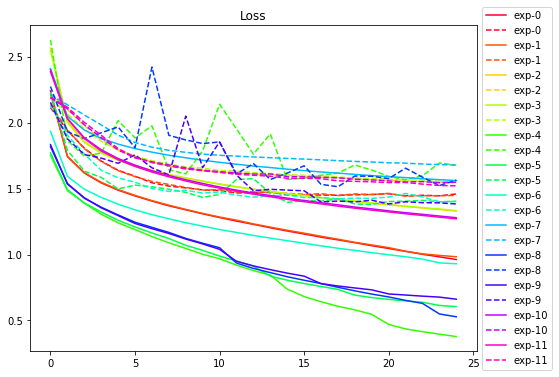

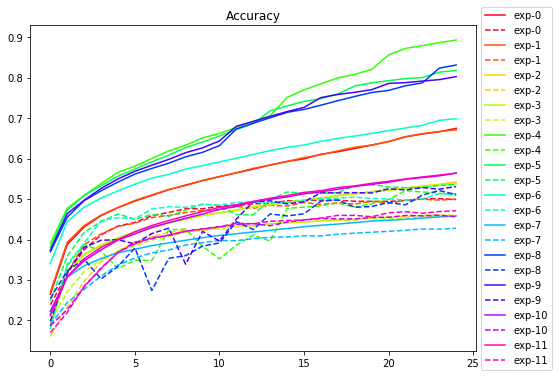

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()